In [1]:
from azureml.core import Workspace, Dataset, Datastore
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, lit, sum, when, expr
from pyspark.sql.functions import sum as spark_sum
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

/home/administrador/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: azureml.core: AzureML support for Python 3.7 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.7 workflows that use AzureML will continue to work without modification, but Python 3.7 users will no longer get access to the latest AzureML features and bugfixes. We recommend that you upgrade to Python 3.8 or newer. To disable SDK V1 deprecation warning set the environment variable AZUREML_DEPRECATE_WARNING to 'False'
  """Entry point for launching an IPython kernel.


In [2]:
APP_NAME = "BotnetDetection"
MASTER = "local[4]"


conf = SparkConf().setAppName(APP_NAME).setMaster(MASTER)
sc = SparkContext(conf=conf)
spark= SparkSession(sc)

24/03/10 13:18:02 WARN Utils: Your hostname, vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/03/10 13:18:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/03/10 13:18:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
subscription_id = '95598df3-7982-4621-a42d-21bde1335164'
resource_group = 'trabajo-final'
workspace_name = 'ogvd-trabajo-final'

workspace = Workspace(subscription_id, resource_group, workspace_name)

datastore = Datastore.get(workspace, "workspaceblobstore")
#dataset = Dataset.Tabular.from_delimited_files(path=(datastore, 'quickstart-output/realtor-data-clean.csv'))
dataset = Dataset.Tabular.from_delimited_files(path=(datastore, 'UI/2024-03-04_190347_UTC/realtor-data.csv'))
df = dataset.to_spark_dataframe()

{'infer_column_types': 'False', 'activity': 'to_spark_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_spark_dataframe', 'activityApp': 'TabularDataset'}


In [4]:
df.head()

/home/administrador/miniconda3/envs/py37/lib/python3.7/site-packages/azureml/dataprep/api/_aml_auth_resolver.py:60: FutureWarning: azureml.core: AzureML support for Python 3.7 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.7 workflows that use AzureML will continue to work without modification, but Python 3.7 users will no longer get access to the latest AzureML features and bugfixes. We recommend that you upgrade to Python 3.8 or newer. To disable SDK V1 deprecation warning set the environment variable AZUREML_DEPRECATE_WARNING to 'False'
  from azureml.core import Workspace
/home/administrador/miniconda3/envs/py37/lib/python3.7/site-packages/azureml/dataprep/api/_aml_auth_resolver.py:60: FutureWarning: azureml.core: AzureML support for Python 3.7 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.7 workflows that use AzureML will continue to work without modification, but Python 3.7 users will no long

Row(status='for_sale', bed=3.0, bath=2.0, acre_lot=0.12, city='Adjuntas', state='Puerto Rico', zip_code=601.0, house_size=920.0, prev_sold_date=None, price=105000.0)

### Conversión de unidades

In [5]:
# Asumiendo que 'df' es tu DataFrame de Spark
df = df.withColumn("house_size", F.col("house_size") / 10.764)\
       .withColumn("acre_lot", F.col("acre_lot") / 10.764)

### Conteo de valores faltantes y visualización

/home/administrador/miniconda3/envs/py37/lib/python3.7/site-packages/azureml/dataprep/api/_aml_auth_resolver.py:60: FutureWarning: azureml.core: AzureML support for Python 3.7 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.7 workflows that use AzureML will continue to work without modification, but Python 3.7 users will no longer get access to the latest AzureML features and bugfixes. We recommend that you upgrade to Python 3.8 or newer. To disable SDK V1 deprecation warning set the environment variable AZUREML_DEPRECATE_WARNING to 'False'
  from azureml.core import Workspace
/home/administrador/miniconda3/envs/py37/lib/python3.7/site-packages/azureml/dataprep/api/_aml_auth_resolver.py:60: FutureWarning: azureml.core: AzureML support for Python 3.7 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.7 workflows that use AzureML will continue to work without modification, but Python 3.7 users will no long

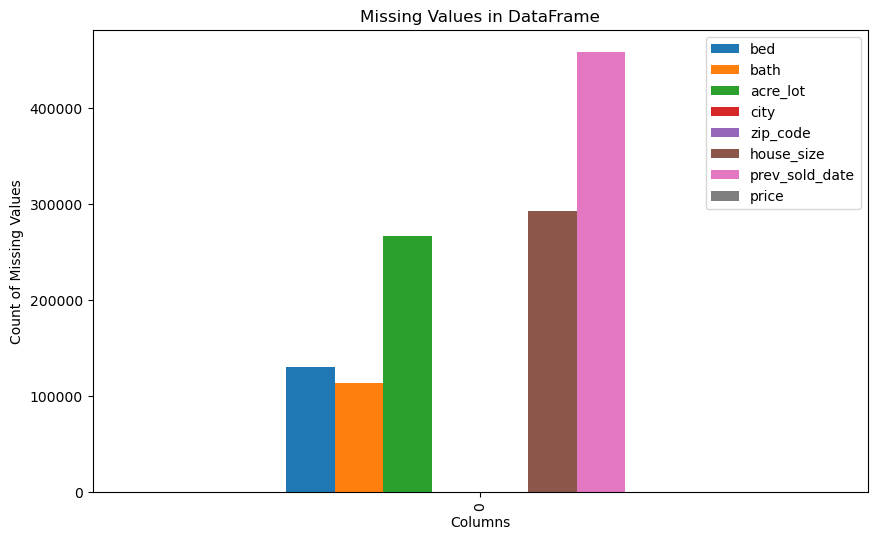

In [6]:
df_missing = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])
df_missing_pd = df_missing.toPandas()

df_missing_pd.loc[:, (df_missing_pd != 0).any(axis=0)].plot.bar(figsize=(10, 6))
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.title('Missing Values in DataFrame')
plt.show()

### Eliminar filas donde "price" es nulo

In [7]:
df = df.na.drop(subset=["price"])

### Gráfico de dispersión con escala logarítmica

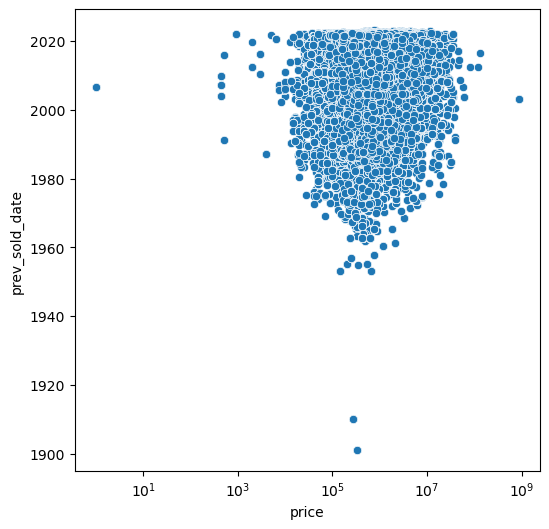

In [8]:
df_pd = df.select("price", "prev_sold_date").toPandas()
df_pd['prev_sold_date'] = pd.to_datetime(df_pd['prev_sold_date'])

f, ax = plt.subplots(figsize=(6, 6))
ax.set(xscale="log")
sns.scatterplot(data=df_pd, x="price", y="prev_sold_date")
plt.show()

### Eliminar columna "prev_sold_date"

In [9]:
df = df.drop("prev_sold_date")

### Visualización de valores faltantes y visualización de conteo de filas con valores faltantes

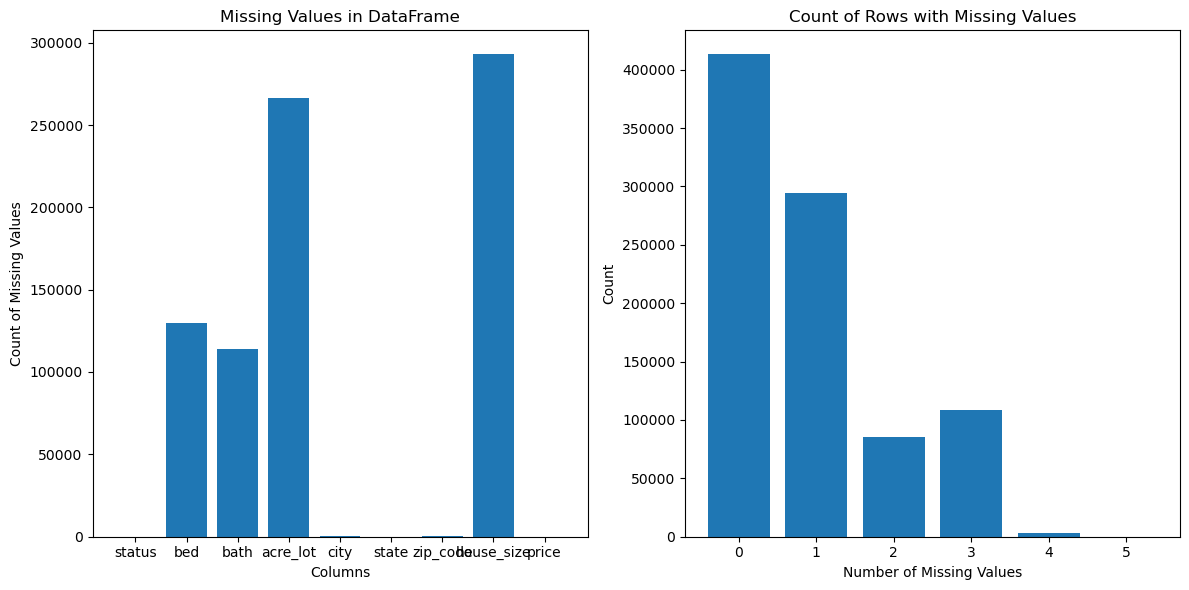

In [10]:
df_with_missing_count = df.withColumn("num_missing", expr(" + ".join(["(case when " + c + " is null then 1 else 0 end)" for c in df.columns])))
df_rows_missing = df_with_missing_count.groupBy("num_missing").count()
df_columns_missing = df.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

df_columns_missing_pd = df_columns_missing.toPandas()
df_rows_missing_pd = df_rows_missing.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Valores faltantes por columna
axes[0].bar(df_columns_missing_pd.columns, df_columns_missing_pd.iloc[0])
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Count of Missing Values')
axes[0].set_title('Missing Values in DataFrame')

# Plot 2: Conteo de filas por número de valores faltantes
axes[1].bar(df_rows_missing_pd['num_missing'], df_rows_missing_pd['count'])
axes[1].set_xlabel('Number of Missing Values')
axes[1].set_ylabel('Count')
axes[1].set_title('Count of Rows with Missing Values')

plt.tight_layout()
plt.show()

### Eliminar todas las filas con valores faltantes

In [11]:
df = df.na.drop()

### Convertir "status" a variables dummy

Como todos los status son iguales, no aplica

In [13]:
if 0:
    stringIndexer = StringIndexer(inputCol="status", outputCol="status_indexed")
    model = stringIndexer.fit(df)
    df = model.transform(df)

    encoder = OneHotEncoder(inputCols=["status_indexed"], outputCols=["status_vec"])
    df = encoder.fit(df).transform(df)

    # Eliminar columnas originales y de índice si es necesario
    df = df.drop("status", "status_indexed")

df = df.drop("status")

### Limpiar categorías no utilizadas y agregar columnas de precio medio

In [14]:
# Asignación de precios medios por ciudad, estado y código postal
w_city = Window.partitionBy('city')
w_state = Window.partitionBy('state')
w_zip = Window.partitionBy('zip_code')

df = df.withColumn('mean_city_price', F.avg('price').over(w_city))\
       .withColumn('mean_state_price', F.avg('price').over(w_state))\
       .withColumn('mean_zip_price', F.avg('price').over(w_zip))

### Eliminar columnas ["city", "state", "zip_code"]

In [15]:
eda_df = df
eda_df = eda_df.drop("city", "state", "zip_code")

### Matriz de correlación y visualización

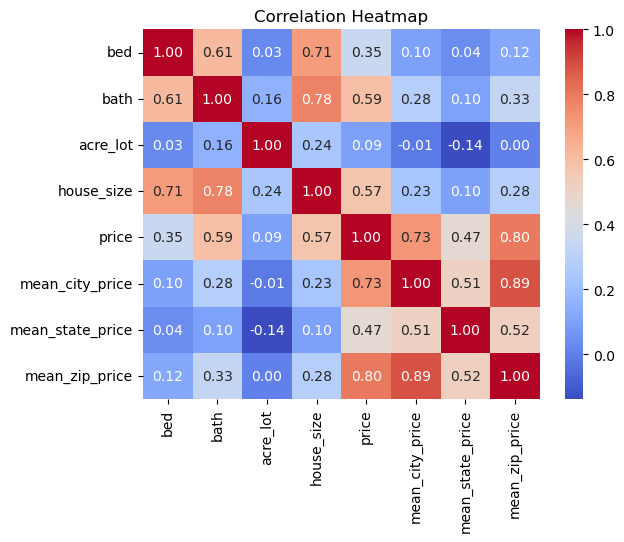

In [16]:
eda_df_pd = eda_df.toPandas()
correlation_matrix_pd = eda_df_pd.corr(method='spearman')
sns.heatmap(correlation_matrix_pd, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Gráfico de pares y distribución de 'price'

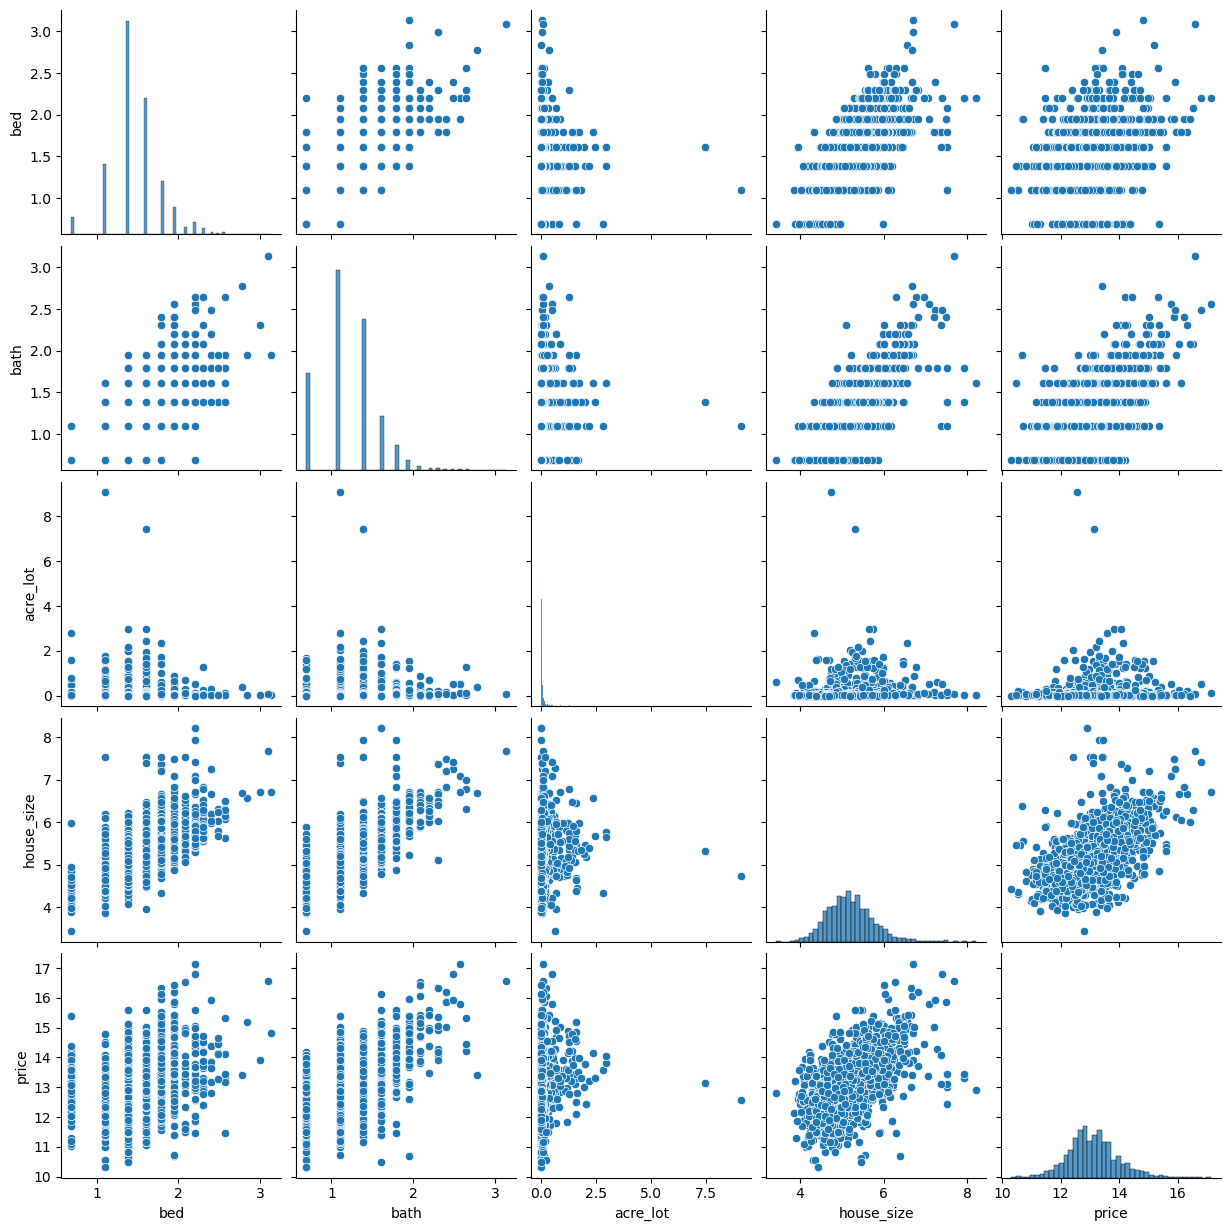

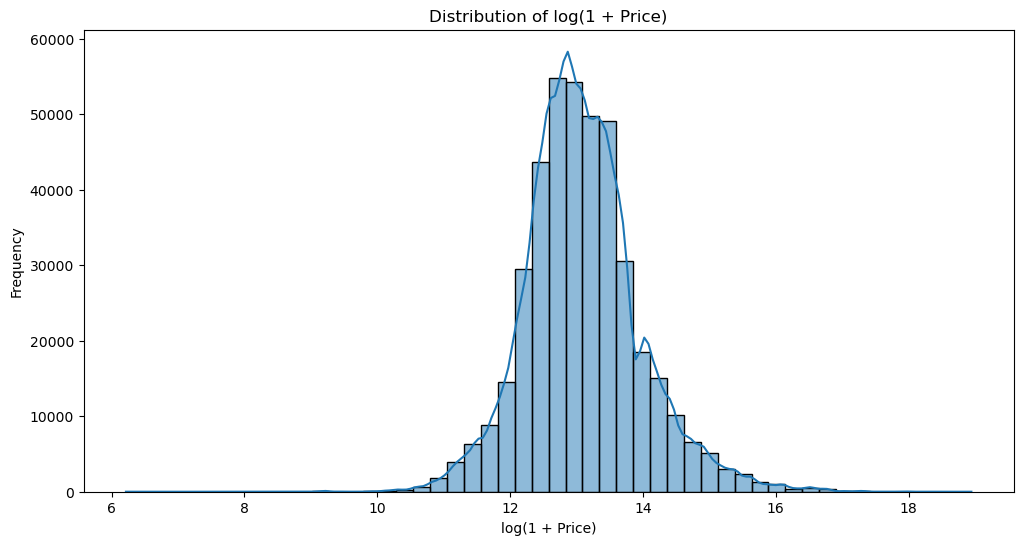

In [17]:
NUM_SAMPLES = 2000
subset_df = eda_df.sample(False, NUM_SAMPLES / eda_df.count())  # Ajusta la fracción según el tamaño del df
subset_df_pd = subset_df.toPandas()
# Para el gráfico de pares de variables numéricas
sns.pairplot(np.log(1 + subset_df_pd[['bed', 'bath', 'acre_lot', 'house_size', 'price']]))
plt.show()


# Para la distribución de 'price'
plt.figure(figsize=(12, 6))
sns.histplot(np.log(1 + eda_df_pd['price']), kde=True, bins=50)
plt.title('Distribution of log(1 + Price)')
plt.xlabel('log(1 + Price)')
plt.ylabel('Frequency')
plt.show()
